In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
#%matplotlib inline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_yearly, plot_forecast_component
from time import strptime, strftime
from funcs import *
from bokeh.plotting import figure, output_file, show

In [2]:
allrev = pd.read_excel('RevenueAll.xls', index_col=0, skiprows=1)
allrev.dropna(inplace=True)
allrev.head()

,Net Revenue USD
2010-01-01,155685.808563
2010-01-02,152832.926838
2010-01-03,127815.434697
2010-01-04,120453.015947
2010-01-05,120103.740545


In [3]:
allrev.tail()

,Net Revenue USD
2018-09-12,59692.445439
2018-09-13,63027.416204
2018-09-14,77172.168079
2018-09-15,75877.772882
2018-09-16,66457.428031


##  Aggregate by month, then forecast:

In [4]:
allrev_monthly = allrev.resample('M').sum()
allrev_monthly = allrev_monthly[:-1]
allrev_monthly.tail()

,Net Revenue USD
2018-04-30,2.076585e+06
2018-05-31,2.147734e+06
2018-06-30,2.074749e+06
2018-07-31,2.103966e+06
2018-08-31,2.093619e+06


In [5]:
allrev_monthly.head()

,Net Revenue USD
2010-01-31,3.968248e+06
2010-02-28,3.875195e+06
2010-03-31,4.210071e+06
2010-04-30,4.114018e+06
2010-05-31,4.172477e+06


In [6]:
# freq='M', ie month end:
netrev_monthly_series, netrev_monthly_forecast = fitandforecast(allrev_monthly, 'Net Revenue USD', mode='multiplicative', 
                                                                periods=16, freq='M', interval_width=0.9)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\JamieG\AppData\Local\conda\conda\envs\ds\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


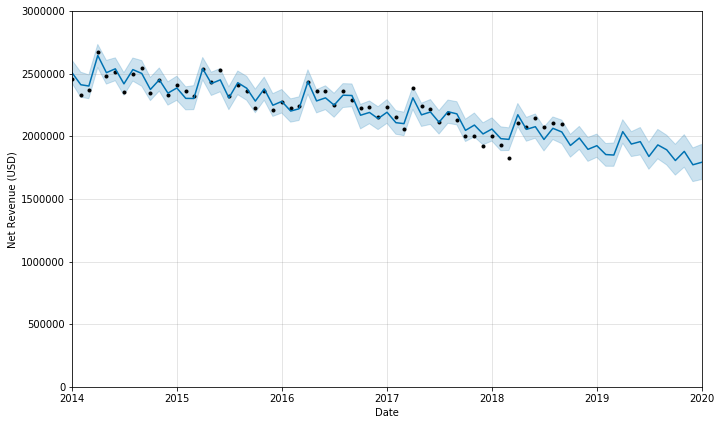

In [7]:
netrev_monthly_series.plot(netrev_monthly_forecast, xlabel="Date", ylabel="Net Revenue (USD)", )
plt.gca().set_xlim(pd.Timestamp('2014'), pd.Timestamp('2020'))
plt.gca().set_ylim([0,3000000])
plt.savefig('revenue.pdf')

In [9]:
selectcols = ['ds', 'yhat', 'yhat_upper', 'yhat_lower']
renamecols = ['year', 'revenue_forecast', 'upper_estimate', 'lower_estimate'] 
future_only= netrev_monthly_forecast.iloc[-16:,:]
output = future_only[selectcols].rename(columns=dict(zip(selectcols, renamecols)))
output.insert(loc=1, column='month', value=output['year'].dt.strftime('%m') )
output['year'] = output['year'].dt.strftime('%Y')

output.to_csv('output/net_revenue_forecast_monthly.csv', index=False)


In [10]:
output.head()

,year,month,revenue_forecast,upper_estimate,lower_estimate
104,2018,09,1.926081e+06,2.014344e+06,1.832524e+06
105,2018,10,1.985320e+06,2.078532e+06,1.894602e+06
106,2018,11,1.895161e+06,1.989626e+06,1.799104e+06
107,2018,12,1.924311e+06,2.016840e+06,1.831301e+06
108,2019,01,1.853634e+06,1.941412e+06,1.760189e+06


## Forecast daily, then aggregate:

In [11]:
allrev.tail()

,Net Revenue USD
2018-09-12,59692.445439
2018-09-13,63027.416204
2018-09-14,77172.168079
2018-09-15,75877.772882
2018-09-16,66457.428031


In [12]:
netrev_daily_series, netrev_daily_forecast = fitandforecast(allrev, 'Net Revenue USD', mode='multiplicative', 
                                                                periods=470, freq='D', interval_width=0.9)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\JamieG\AppData\Local\conda\conda\envs\ds\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


(35000, 100000)

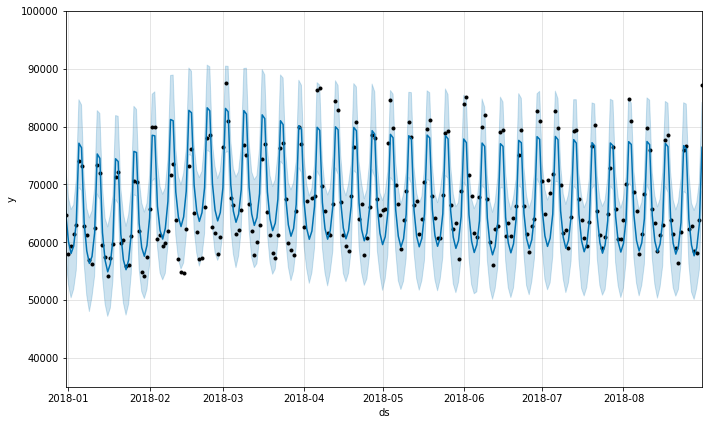

In [13]:
netrev_daily_series.plot(netrev_daily_forecast)
plt.gca().set_xlim(pd.Timestamp('2017-12-31'), pd.Timestamp('2018-08-31'))
plt.gca().set_ylim([35000, 100000])

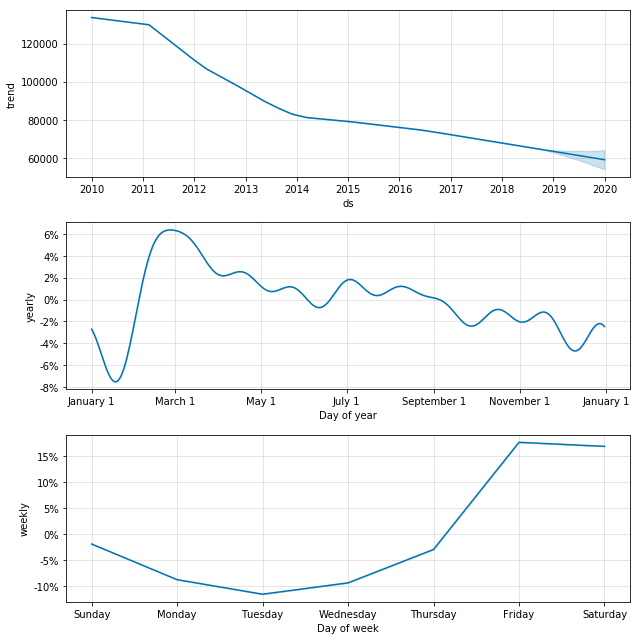

In [14]:
netrev_components=netrev_daily_series.plot_components(netrev_daily_forecast)

Now we compute the monthly forecast (version 2) by aggregating the forecast by month:

In [15]:
netrev_forecast2 = netrev_daily_forecast.set_index('ds').resample('M').sum()

In [16]:
netrev_forecast2.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2010-01-31,4.139067e+06,3.725687e+06,4.191010e+06,4.139067e+06,4.139067e+06,-1.362607,-1.362607,-1.362607,3.250155e-01,3.250155e-01,3.250155e-01,-1.687623,-1.687623,-1.687623,0.0,0.0,0.0,3.957149e+06
2010-02-28,3.730938e+06,3.668694e+06,4.087924e+06,3.730938e+06,3.730938e+06,1.124149,1.124149,1.124149,6.021954e-13,6.021954e-13,6.021954e-13,1.124149,1.124149,1.124149,0.0,0.0,0.0,3.880641e+06
2010-03-31,4.122296e+06,4.046745e+06,4.508388e+06,4.122296e+06,4.122296e+06,1.156920,1.156920,1.156920,-2.955820e-01,-2.955820e-01,-2.955820e-01,1.452502,1.452502,1.452502,0.0,0.0,0.0,4.276173e+06
2010-04-30,3.980928e+06,3.867578e+06,4.314953e+06,3.980928e+06,3.980928e+06,0.812351,0.812351,0.812351,1.464122e-01,1.464122e-01,1.464122e-01,0.665938,0.665938,0.665938,0.0,0.0,0.0,4.088747e+06
2010-05-31,4.104956e+06,3.917728e+06,4.384648e+06,4.104956e+06,4.104956e+06,0.352218,0.352218,0.352218,6.200100e-02,6.200100e-02,6.200100e-02,0.290217,0.290217,0.290217,0.0,0.0,0.0,4.151591e+06


(0, 3000000)

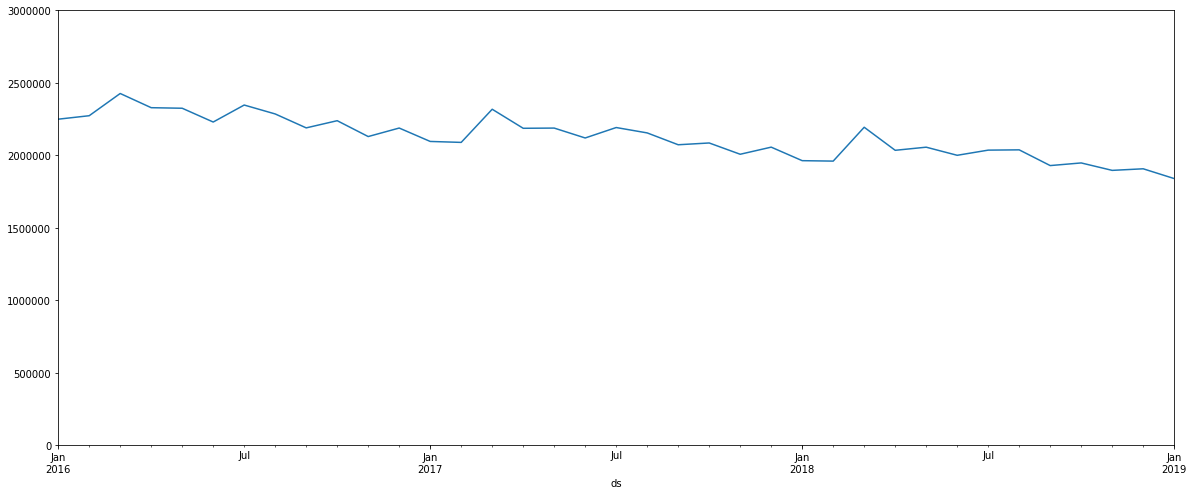

In [17]:
netrev_forecast2['yhat'].plot(legend=False, figsize=(20,8))
#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().set_xlim(pd.Timestamp('2016'), pd.Timestamp('2019'))
plt.gca().set_ylim(0, 3000000)

(1000000, 3000000)

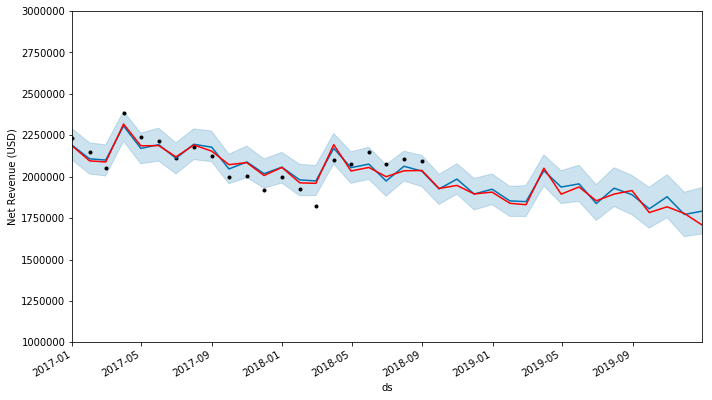

In [18]:
netrev_monthly_series.plot(netrev_monthly_forecast, xlabel="Date", ylabel="Net Revenue (USD)")
netrev_forecast2['yhat'].plot(color='red', legend=False)
plt.gca().set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2019-12-31'))
plt.gca().set_ylim([1000000, 3000000])